## Tree-based Models

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
rate_df = pd.read_csv('rates_clean.csv', engine = 'python')

rate_df['neighbourhood_group_cleansed'] = rate_df['neighbourhood_group_cleansed'].astype('category')
rate_df['neighbourhood_cleansed'] = rate_df['neighbourhood_cleansed'].astype('category')
rate_df['property_type'] = rate_df['property_type'].astype('category')
rate_df['room_type'] = rate_df['room_type'].astype('category')
rate_df['bedrooms'] = rate_df['bedrooms'].astype('category')
rate_df['bathrooms'] = rate_df['bathrooms'].astype('category')

rate_df.head()

,neighbourhood_group_cleansed,neighbourhood_cleansed,property_type,room_type,bedrooms,bathrooms,guests_included,price,lnprice
0,Manhattan,Midtown,Apartment,Entire home/apt,0,1.0,1,225,5.416100
1,Brooklyn,Clinton Hill,Guest suite,Entire home/apt,1,1.0,1,89,4.488636
2,Manhattan,Murray Hill,Apartment,Entire home/apt,1,1.0,2,200,5.298317
3,Manhattan,Hell's Kitchen,Apartment,Private room,1,1.0,1,79,4.369448
4,Manhattan,Upper West Side,Apartment,Private room,1,1.0,1,79,4.369448


In [3]:
full_df = rate_df

full_ddf = pd.get_dummies(full_df['neighbourhood_group_cleansed'], drop_first = True, prefix = 'borough:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['neighbourhood_cleansed'], drop_first = True, prefix = 'hood:')], 
                     axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['property_type'], drop_first = True, prefix = 'property:')], 
                     axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['room_type'],  prefix = 'room:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['bedrooms'],  prefix = 'bed:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['bathrooms'],  prefix = 'bath:')], axis = 1)

full_df = full_df.drop(['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'property_type', 
                        'room_type', 'bedrooms', 'bathrooms', 'price'], axis = 1)

y = pd.DataFrame(full_df['lnprice']).reset_index(drop = True)

full_df = full_df.drop('lnprice', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [4]:
random.seed(42)
X_train = X.sample(frac = 0.7).sort_index()
y_train = y[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
y_test = y[~X.index.isin(X_train.index)]

### Decision Tree Regression

In [5]:
dt_max_depth_arr = np.linspace(1, 15, 15).astype(int)
dt_min_leaf_arr = np.linspace(1, 10, 10).astype(int)

dt = GridSearchCV(DecisionTreeRegressor(random_state = 42), 
                  param_grid = {'max_depth' : dt_max_depth_arr, 'min_samples_leaf' : dt_min_leaf_arr}, 
                  scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

dt.fit(X_train, y_train)

dt_df = pd.DataFrame(dt.cv_results_)

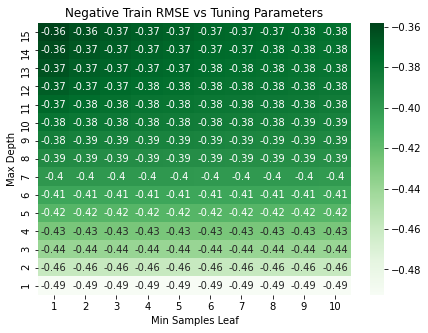

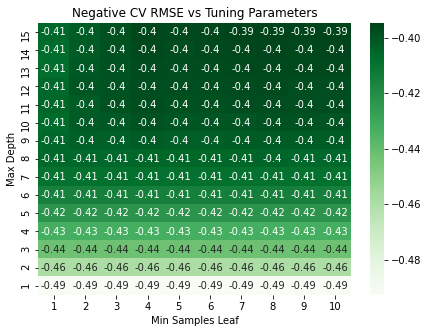

In [6]:
dt_train_rmse_mat = dt_df['mean_train_score'].values.reshape(len(dt_max_depth_arr), len(dt_min_leaf_arr))
plt.figure(figsize = (7, 5))
ax = sns.heatmap(pd.DataFrame(dt_train_rmse_mat, columns = dt_min_leaf_arr, 
                              index = dt_max_depth_arr).iloc[::-1], annot = True, cmap = 'Greens')
ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Negative Train RMSE vs Tuning Parameters')
plt.show()

dt_cv_rmse_mat = dt_df['mean_test_score'].values.reshape(len(dt_max_depth_arr), len(dt_min_leaf_arr))
plt.figure(figsize = (7, 5))
ax = sns.heatmap(pd.DataFrame(dt_cv_rmse_mat, columns = dt_min_leaf_arr, 
                              index = dt_max_depth_arr).iloc[::-1], annot = True, cmap = 'Greens')
ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Negative CV RMSE vs Tuning Parameters')
plt.show()

In [7]:
print('Best Parameters: {}'.format(dt.best_params_))
print('Best Negative Cross-Validation RMSE: {:.4f}'.format(dt.best_score_))

pred_dt = dt.predict(X_test)

print('Test RMSE: {:.4f}'.format(mean_squared_error(y_test, pred_dt, squared = False)))
print('Test MAE: {:.4f}'.format(mean_absolute_error(y_test, pred_dt)))
print('Test R2: {:.4f}'.format(r2_score(y_test, pred_dt)))

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 8}
Best Negative Cross-Validation RMSE: -0.3947
Test RMSE: 0.3905
Test MAE: 0.2981
Test R2: 0.6268


### Random Forest Regression

In [8]:
rf_n_estimators_arr = [10, 20, 50, 100, 200, 500, 1000, 2000]

rf = GridSearchCV(RandomForestRegressor(random_state = 42), 
                  param_grid = {'n_estimators' : rf_n_estimators_arr}, 
                  scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

rf.fit(X_train, y_train)

rf_df = pd.DataFrame(rf.cv_results_)

In [9]:
rf_df[['param_n_estimators', 'mean_train_score', 'mean_test_score']]

,param_n_estimators,mean_train_score,mean_test_score
0,10,-0.327519,-0.399296
1,20,-0.325960,-0.397751
2,50,-0.324904,-0.396252
3,100,-0.324643,-0.395946
4,200,-0.324416,-0.395964
5,500,-0.324321,-0.396016
6,1000,-0.324290,-0.396000
7,2000,-0.324287,-0.395966


In [10]:
print('Best Parameters: {}'.format(rf.best_params_))
print('Best Negative Cross-Validation RMSE: {:.4f}'.format(rf.best_score_))

pred_rf = rf.predict(X_test)

print('Test RMSE: {:.4f}'.format(mean_squared_error(y_test, pred_rf, squared = False)))
print('Test MAE: {:.4f}'.format(mean_absolute_error(y_test, pred_rf)))
print('Test R2: {:.4f}'.format(r2_score(y_test, pred_rf)))

Best Parameters: {'n_estimators': 100}
Best Negative Cross-Validation RMSE: -0.3959
Test RMSE: 0.3866
Test MAE: 0.2914
Test R2: 0.6343


### AdaBoosted Decision Tree Regression

In [11]:
adt_learning_rate_arr = np.logspace(-4, 0, 5)
adt_n_estimators_arr = [10, 20, 50, 100, 200, 500, 1000]

adt = GridSearchCV(AdaBoostRegressor(random_state = 42), 
                   param_grid = {'learning_rate' : adt_learning_rate_arr, 'n_estimators' : adt_n_estimators_arr}, 
                   scoring = 'neg_root_mean_squared_error', cv = 5, return_train_score = True)

adt.fit(X_train, y_train)

adt_df = pd.DataFrame(adt.cv_results_)

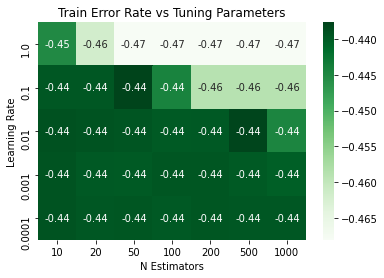

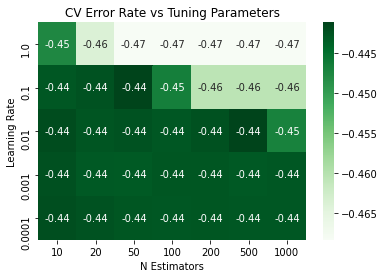

In [12]:
adt_train_rmse_mat = adt_df['mean_train_score'].values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_train_rmse_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

adt_cv_rmse_mat = adt_df['mean_test_score'].values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_cv_rmse_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'CV Error Rate vs Tuning Parameters')
plt.show()

In [13]:
print('Best Parameters: {}'.format(adt.best_params_))
print('Best Negative Cross-Validation RMSE: {:.4f}'.format(adt.best_score_))

pred_adt = adt.predict(X_test)

print('Test RMSE: {:.4f}'.format(mean_squared_error(y_test, pred_adt, squared = False)))
print('Test MAE: {:.4f}'.format(mean_absolute_error(y_test, pred_adt)))
print('Test R2: {:.4f}'.format(r2_score(y_test, pred_adt)))

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best Negative Cross-Validation RMSE: -0.4412
Test RMSE: 0.4400
Test MAE: 0.3424
Test R2: 0.5262


### XGBoost Regression

In [14]:
xgb = XGBRegressor(random_state = 42, objective = 'reg:squarederror', learning_rate = 0.1, n_estimators = 100, max_depth = 5, 
                   min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)

xgb.fit(X_train.values, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [15]:
pred_xgb = xgb.predict(X_test.values)

print('Test RMSE: {:.4f}'.format(mean_squared_error(y_test, pred_xgb, squared = False)))
print('Test MAE: {:.4f}'.format(mean_absolute_error(y_test, pred_xgb)))
print('Test R2: {:.4f}'.format(r2_score(y_test, pred_xgb)))

Test RMSE: 0.3806
Test MAE: 0.2896
Test R2: 0.6455
